In [1]:
%load_ext autoreload

%autoreload 2


In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import ClusterStats.cluster_stats as cs

ModuleNotFoundError: No module named 'ClusterStats'

In [3]:
%matplotlib inline

In [4]:
def generate_trial(N = 100, sig = 1):
    a = np.random.rand(100)
    x = np.linspace(-10, 10, 100)
    y = np.exp(-(x**2)/2) * np.random.rand() * sig
    return a + y

In [68]:
# create new data 
N_trials = 1000
data_cols = [str(i) for i in np.linspace(-10, 10, 100).tolist()]

df = pd.DataFrame(columns=data_cols)
df['cond'] = 0
for i in range(N_trials):
    df.loc[i, data_cols] = generate_trial(sig=0.2)
    df.loc[i, 'cond'] = 1
    
for i in range(N_trials, N_trials * 2):
    df.loc[i, data_cols] = generate_trial(sig=0)
    df.loc[i, 'cond'] = 0

df.to_csv('trials.csv')

In [5]:
# or read from disk
df = pd.read_csv('trials.csv')
data_cols = [str(i) for i in np.linspace(-10, 10, 100).tolist()]

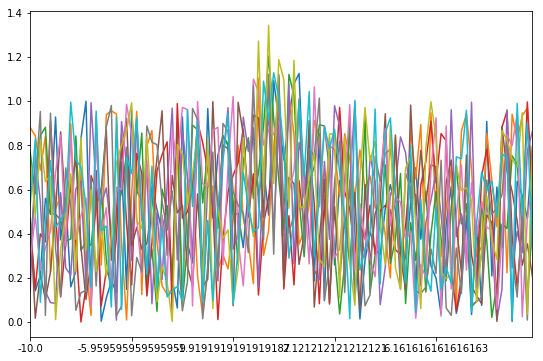

In [64]:
df.head(10)[data_cols].T.plot(legend=None, figsize=(9, 6))

In [74]:
data = df[data_cols].values
labels = df['cond'].values
unique_labels = np.array([1, 0])
stat, pval = cs.site_statistics_ttest_ind(data, labels, unique_labels)


In [66]:
cluster_stats_obs, clusters_obs = cs.clust_stats_1d(stat, pval, threshold=0.05)

In [67]:
cluster_stats_obs

array([196.04668906,   3.98900313,   2.72161191,   2.43744057,
         2.0932748 ,   1.96411297])

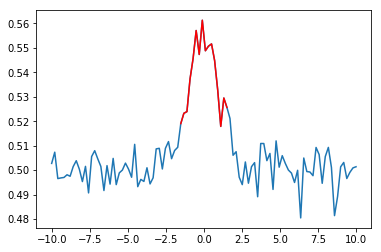

In [75]:
x = np.linspace(-10, 10, 100)
plt.plot(x, np.mean(data, axis=0))
plt.plot(x[cl[0]], np.mean(data, axis=0)[cl[0]], 'r')
#plt.plot(np.linspace(-10, 10, 100), np.log(pval))

In [53]:
cluster_stats_obs

array([86.01884784,  2.82275795,  2.55163993, -2.02536981, -2.11228369,
       -2.11611036])

In [ ]:
%%timeit
cluster_stats, clusters = cs.clust_stats_opencv(stat, pval, threshold=0.05)

In [ ]:
%timeit sx = cs.monte_carlo_iteration(data, labels, unique_labels=unique_labels)

In [ ]:
%lprun -f cs.site_statistics_ttest_ind tt = cs.site_statistics_ttest_ind(df, 'cond', data_cols)

In [ ]:
import itertools

In [ ]:
%load_ext line_profiler

In [ ]:
def run_monte_carlo_map(df, col_groups, col_values, n_repetitions, connectivity='1d', site_alpha=0.05):
    data = df[col_values].values
    labels = df[col_groups].values
    unique_labels = np.unique(labels).astype(np.int)[::-1]
    
    stats_mc = map(cs.monte_carlo_iteration,
                            *[itertools.repeat(d, n_repetitions) for d in (data, labels, unique_labels,
                                                                           connectivity,
                                                                           site_alpha)])
                            # chunksize=100)
    stats_mc = np.array(list(stats_mc))
    stats_mc.sort()
    stats_mc = stats_mc[::-1]
    idx = np.linspace(0, 1, n_repetitions)
    stats_mc = pd.Series(data=stats_mc, index=idx)
    return stats_mc


In [79]:
%time stats_mc = cs.run_monte_carlo(df, 'cond', data_cols, n_repetitions=100, parallel=False)

CPU times: user 1.76 s, sys: 453 ms, total: 2.21 s
Wall time: 2.22 s


In [56]:
stats_mc

0.000000    6.078455
0.001001    5.707885
0.002002    5.517997
0.003003    5.363904
0.004004    5.348555
0.005005    5.339308
0.006006    5.217473
0.007007    5.168608
0.008008    5.148378
0.009009    5.114644
0.010010    5.044274
0.011011    4.989697
0.012012    4.945719
0.013013    4.938930
0.014014    4.933852
0.015015    4.903477
0.016016    4.879301
0.017017    4.826916
0.018018    4.791255
0.019019    4.788465
0.020020    4.760624
0.021021    4.759075
0.022022    4.758419
0.023023    4.716827
0.024024    4.703871
0.025025    4.699458
0.026026    4.641967
0.027027    4.626908
0.028028    4.612317
0.029029    4.603118
              ...   
0.970971   -2.149475
0.971972   -2.150815
0.972973   -2.160790
0.973974   -2.166574
0.974975   -2.170297
0.975976   -2.183904
0.976977   -2.185907
0.977978   -2.189620
0.978979   -2.193037
0.979980   -2.195815
0.980981   -2.202038
0.981982   -2.218512
0.982983   -2.243178
0.983984   -2.260845
0.984985   -2.288092
0.985986   -2.293883
0.986987   -2

In [18]:
stats_mc = pd.read_csv('stats_mc.csv', index_col = 0, 
                       header=None, squeeze=True)

In [24]:
stats_mc.where(stats_mc<12.5).dropna().iloc[0]

12.306446215665707

In [30]:
stats_mc[stats_mc<12].head(1).index[0]

0.0014001400140014

In [77]:
cl, stats, cl_pval = cs.cluster_stats_pvalue(df, 'cond', data_cols, n_repetitions=1000)

In [78]:
pval

[0.0,
 0.3063063063063063,
 0.37537537537537535,
 0.7727727727727728,
 0.955955955955956]